# CLASSIFICAÇÃO
Este modelo **prevê se um voo vai ou não gerar prejuízo financeiro para as empresas aéreas**.

___
### Bibliotecas

In [ ]:
# Básico para Data Science
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline / Transformação
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.ensemble import RandomForestClassifier # Random Forest

# Avaliação de performance dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

# Otimização
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

# Balanceamento de classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTENC # dataset com mix de variáveis numéricas e categóricas
#from imblearn.over_sampling import SMOTE # dataset com variáveis numéricas

import sklearn
sklearn.set_config(display='diagram')

# Faz com que o pandas exiba todas as colunas do dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Faz com que todos os plots tenham o estilo do seaborn
sns.set_theme()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

___
### Carregando e inspecionando a base

In [ ]:
# # Rodar direto do ambiente de produção
# df = pd.read_csv('/content/drive/MyDrive/Projeto_DS/Ambiente_Producao/datalake/business/basica_passagem_dolar_completa_2016-2021.csv',
#                  sep=';', encoding='latin-1')

In [ ]:
# Rodar em ambiente local, fazendo o download do arquivo 'base_grupo_3.zip'
# https://drive.google.com/file/d/14VMbZXQssmIMOJQRlUMMyewoEQg2v5hB/view?usp=sharing
from zipfile import ZipFile
zip_file = ZipFile('base_grupo_3.zip')
df = pd.read_csv(zip_file.open('base_grupo_3.csv'),sep=';', encoding='latin-1')

In [ ]:
df.head()

,dt,nr_ano,nr_mes,nr_dia,nm_dia_semana,sg_empresa_icao,hr_partida_real,hr_chegada_real,sg_icao_origem,sg_icao_destino,nm_regiao_origem,nm_regiao_destino,sg_uf_origem,sg_uf_destino,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,kg_payload,kg_peso,kg_carga_paga,kg_carga_gratis,kg_correio,nr_ask,nr_rpk,nr_atk,nr_rtk,lf_passag,lf_peso,rend_combustivel,dolar,ticket_medio
0,2016-01-02,2016,1,2,SAB,ONE,05:58:00,09:01:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.05,8480,162,156,0,18100,14027,0,0,0,311040.0,299520.0,34752.0,26931.0,0.962963,0.774948,0.2264,3.9973,540.0
1,2016-01-03,2016,1,3,DOM,ONE,05:53:00,08:57:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.07,9009,162,158,1,18500,14134,0,0,0,311040.0,303360.0,35520.0,26993.0,0.975309,0.759938,0.2131,3.9973,540.0
2,2016-01-04,2016,1,4,SEG,ONE,06:00:00,09:05:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.08,8758,162,162,0,18500,14508,0,0,0,311040.0,311040.0,35520.0,27855.0,1.000000,0.784206,0.2192,3.9973,540.0
3,2016-01-05,2016,1,5,TER,ONE,05:59:00,08:59:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.00,8512,162,144,3,18500,12995,38,0,0,311040.0,276480.0,35520.0,24518.0,0.888889,0.690259,0.2256,3.9973,540.0
4,2016-01-06,2016,1,6,QUA,ONE,05:55:00,09:00:00,SBMO,SBGR,NORDESTE,SUDESTE,AL,SP,A320,1920.0,3.08,8498,162,131,1,18500,11750,33,0,0,311040.0,251520.0,35520.0,22416.0,0.808642,0.631081,0.2259,3.9973,540.0


In [ ]:
# Filtrando anos a serem considerados
df = df[df.nr_ano < 2020]
df = df[df.nr_ano > 2016]
# Selecionando as três maiores empresas
df = df[(df.sg_empresa_icao == 'AZU')|(df.sg_empresa_icao == 'TAM')|(df.sg_empresa_icao == 'GLO')]

In [ ]:
# Inspecionando
df.head(10)

,dt,nr_ano,nr_mes,nr_dia,nm_dia_semana,sg_empresa_icao,hr_partida_real,hr_chegada_real,sg_icao_origem,sg_icao_destino,nm_regiao_origem,nm_regiao_destino,sg_uf_origem,sg_uf_destino,sg_equipamento_icao,km_distancia,nr_horas_voadas,lt_combustivel,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,kg_payload,kg_peso,kg_carga_paga,kg_carga_gratis,kg_correio,nr_ask,nr_rpk,nr_atk,nr_rtk,lf_passag,lf_peso,rend_combustivel,dolar,ticket_medio
781397,2017-01-06,2017,1,6,SEX,AZU,08:18:00,09:41:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.38,2839,106,91,2,11805,8519,606,0,0,71656.0,61516.0,7980.0,5657.0,0.858491,0.708897,0.2381,3.1507,248.0
781398,2017-01-04,2017,1,4,QUA,AZU,15:54:00,17:13:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.32,3109,106,96,4,11285,8611,0,0,0,71656.0,64896.0,7628.0,5618.0,0.905660,0.736497,0.2174,3.1507,248.0
781399,2017-01-04,2017,1,4,QUA,AZU,08:11:00,09:43:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.53,3315,106,103,2,11664,9443,181,0,0,71656.0,69628.0,7884.0,6282.0,0.971698,0.796804,0.2039,3.1507,248.0
781400,2017-01-04,2017,1,4,QUA,AZU,20:03:00,21:19:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.27,2920,106,73,0,11805,6530,147,0,0,71656.0,49348.0,7980.0,4414.0,0.688679,0.553133,0.2315,3.1507,248.0
781401,2017-01-05,2017,1,5,QUI,AZU,15:59:00,17:20:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.35,3249,106,103,4,11732,9333,0,0,0,71656.0,69628.0,7930.0,6106.0,0.971698,0.769987,0.2081,3.1507,248.0
781402,2017-01-05,2017,1,5,QUI,AZU,08:35:00,09:58:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.38,3132,106,87,2,11805,8369,540,0,0,71656.0,58812.0,7980.0,5556.0,0.820755,0.696241,0.2158,3.1507,248.0
781403,2017-01-05,2017,1,5,QUI,AZU,20:12:00,21:36:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.40,3318,106,80,0,11805,7290,356,0,0,71656.0,54080.0,7980.0,4928.0,0.754717,0.617544,0.2037,3.1507,248.0
781404,2017-01-06,2017,1,6,SEX,AZU,15:49:00,17:14:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.42,2990,106,69,1,11197,5779,0,0,0,71656.0,46644.0,7569.0,3855.0,0.650943,0.509314,0.2261,3.1507,248.0
781405,2017-01-07,2017,1,7,SAB,AZU,08:12:00,09:34:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.37,3030,106,101,3,11805,9297,306,0,0,71656.0,68276.0,7980.0,6132.0,0.952830,0.768421,0.2231,3.1507,248.0
781406,2017-01-08,2017,1,8,DOM,AZU,10:30:00,11:43:00,SBCT,SBRJ,SUL,SUDESTE,PR,RJ,E190,676.0,1.22,2903,106,82,5,11715,8275,811,0,0,71656.0,55432.0,7919.0,5340.0,0.773585,0.674328,0.2329,3.1507,248.0


In [ ]:
df.isna().sum()

dt                       0
nr_ano                   0
nr_mes                   0
nr_dia                   0
nm_dia_semana            0
sg_empresa_icao          0
hr_partida_real          0
hr_chegada_real          0
sg_icao_origem           0
sg_icao_destino          0
nm_regiao_origem         0
nm_regiao_destino        0
sg_uf_origem             0
sg_uf_destino            0
sg_equipamento_icao      0
km_distancia             0
nr_horas_voadas          0
lt_combustivel           0
nr_assentos_ofertados    0
nr_passag_pagos          0
nr_passag_gratis         0
kg_payload               0
kg_peso                  0
kg_carga_paga            0
kg_carga_gratis          0
kg_correio               0
nr_ask                   0
nr_rpk                   0
nr_atk                   0
nr_rtk                   0
lf_passag                0
lf_peso                  1
rend_combustivel         0
dolar                    0
ticket_medio             0
dtype: int64

In [ ]:
df = df.dropna()

___
### Transformações
A maior parte das transformações foram feitas no notebook _extract_transform.ipynb_, como a inclusão de novas variáveis (_lf_passag_, _dolar_ e _ticket_medio_) e a redução de caracteres das categorias das colunas (como, por exemplo, de 'SEGUNDA-FEIRA' para 'SEG').

In [ ]:
# Transformando as horas numa variável categórica (excluindo minutos e segundos)
def editar(x): x = re.sub("[^0-9]", "",x); return int(x[0:2])
df['hr_partida_real'] = df['hr_partida_real'].apply(editar)

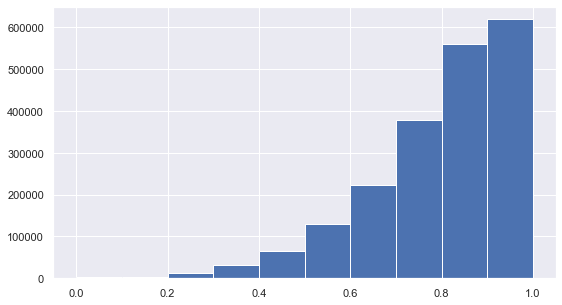

In [ ]:
# Olhando a distribuiçao do LF
plt.figure(figsize=(9,5))
df.lf_passag[df.lf_passag<=1].hist();

In [ ]:
# Aqui, estamos construindo a nossa target 'prejuizo',
# sendo a categoria 1 para voos que dão prejuízo financeiro e 0 para os que não dão.
# Após pesquisas, encontramos a informação de que voos com LF < 0.5 geram prejuizo.
def prejuizo(x):
    if x < 0.5: return 1
    else: return 0
df['prejuizo'] = df['lf_passag'].apply(prejuizo)
df['prejuizo'].value_counts(normalize=True)

0    0.944129
1    0.055871
Name: prejuizo, dtype: float64

___
### Analisando as relações das _features_ com a _target_

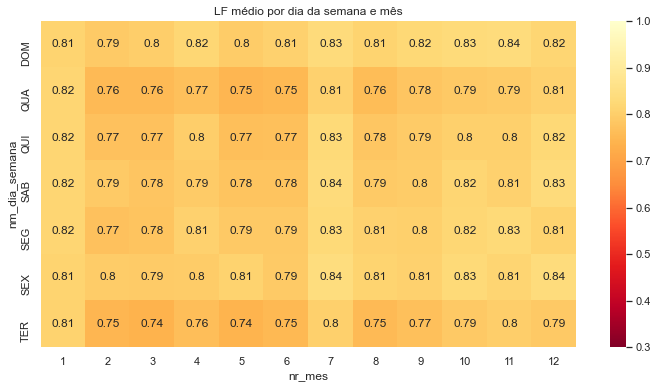

In [ ]:
# Ocupação média por dia da semana e mês (2017-2019)
plt.figure(figsize=(12,6))
plt.title('LF médio por dia da semana e mês')
sns.heatmap(df.pivot_table(index='nm_dia_semana',
                           columns='nr_mes',
                           values='lf_passag',
                           aggfunc='mean'),annot=True,cmap='YlOrRd_r',vmin=0.3,vmax=1);

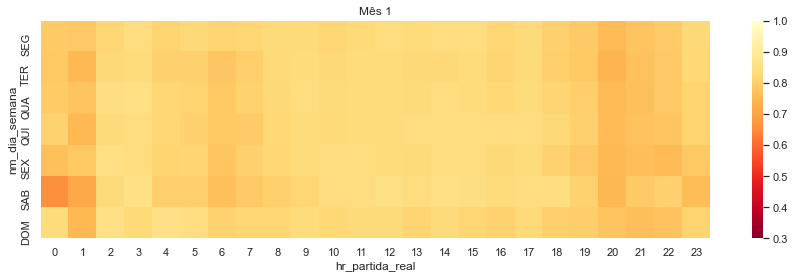

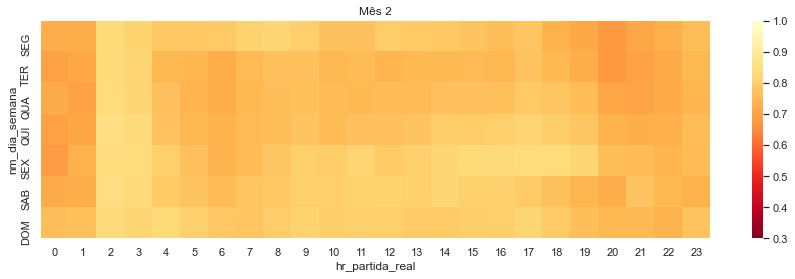

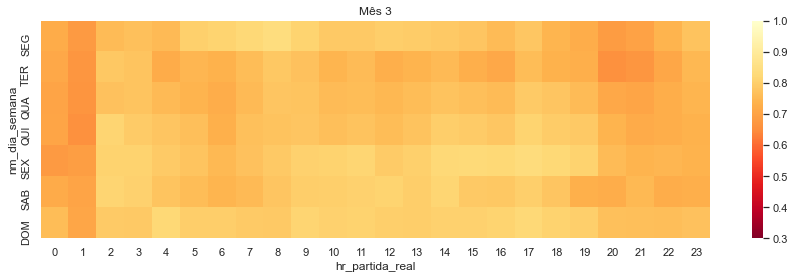

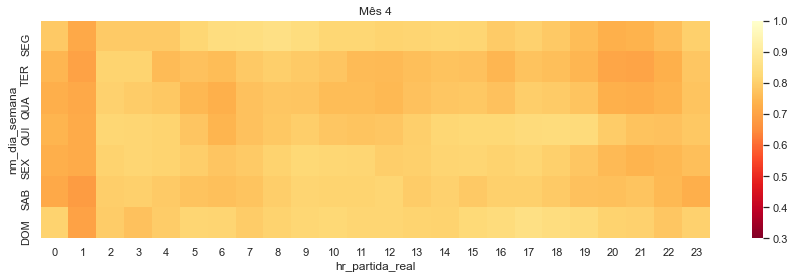

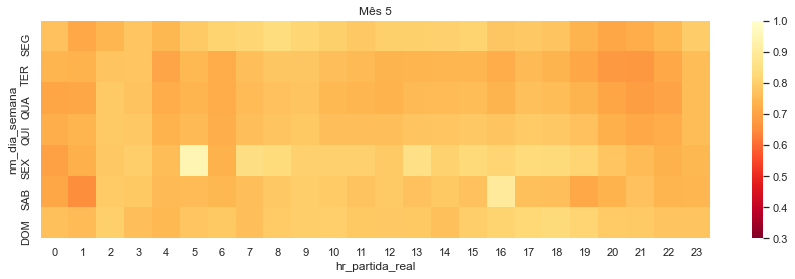

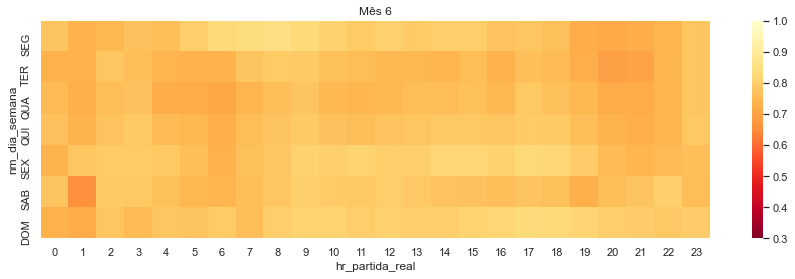

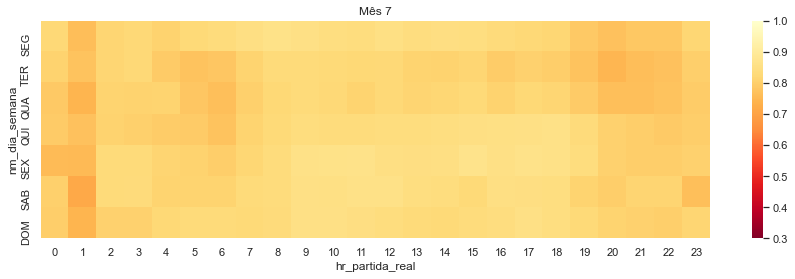

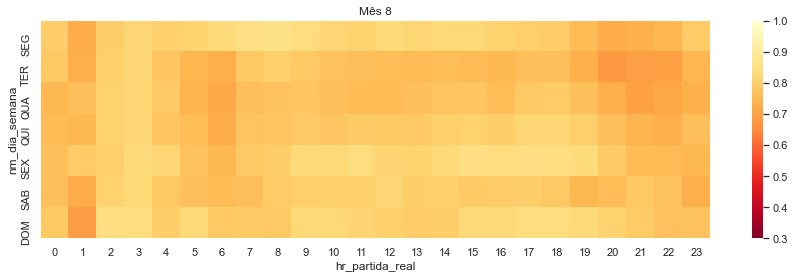

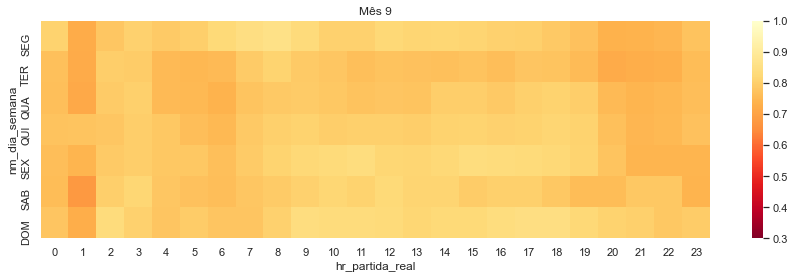

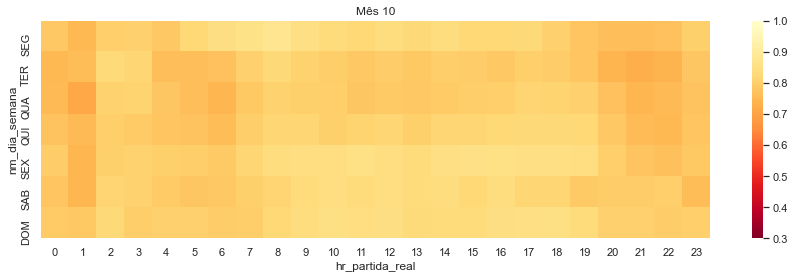

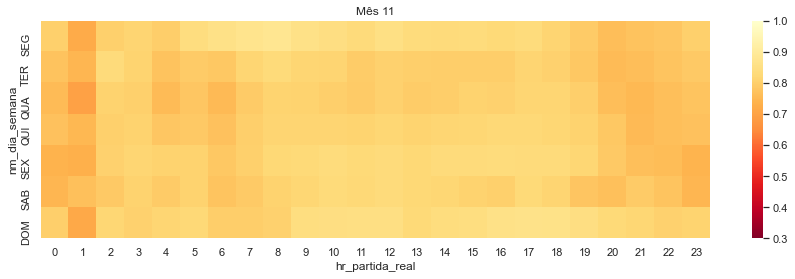

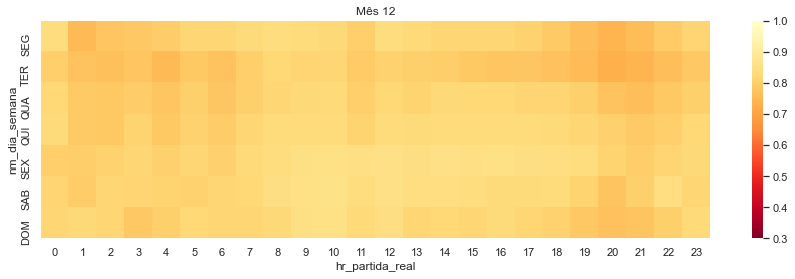

In [ ]:
# Ocupação média por dia da semana e hora do dia (2017-2019)
def editar(x): x = re.sub("[^0-9]", "",x); return int(x[0:2])
for mes in range(1,13):
    df_temp = df[df.nr_mes==mes]
    sns.set(rc={'figure.figsize':(15,4)})
    tmp = df_temp.pivot_table(index=['nm_dia_semana'], columns=['hr_partida_real'],values='lf_passag', aggfunc='mean')
    tmp = tmp.loc[['SEG', 'TER', 'QUA', 'QUI', 'SEX', 'SAB', 'DOM'],:]
    sns.heatmap(tmp,cmap='YlOrRd_r',vmin=0.3,vmax=1)
    plt.title(f'Mês {mes}')
    plt.show()

In [ ]:
# Ocupação média por aeronave (2017-2019)
print(df.groupby('sg_equipamento_icao')['lf_passag'].mean()\
      .sort_values(ascending=False).round(4).to_string())

sg_equipamento_icao
E295    0.8288
B38M    0.8267
A20N    0.8192
B763    0.8164
A321    0.8156
B737    0.8121
A320    0.8022
E190    0.7994
A319    0.7978
E195    0.7931
B738    0.7864
AT72    0.7820
AT76    0.7770
A332    0.7722
B77W    0.7142
A339    0.6695
A359    0.6137


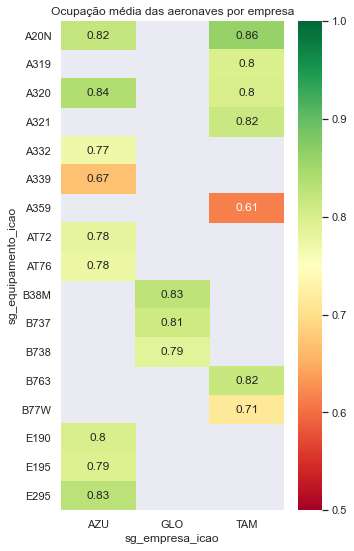

In [ ]:
# Ocupação média das aeronaves por empresa (2017-2019)
plt.figure(figsize=(5,9))
plt.title('Ocupação média das aeronaves por empresa')
sns.heatmap(df.pivot_table(index='sg_equipamento_icao',
                           columns='sg_empresa_icao',
                           values='lf_passag',
                           aggfunc='mean'), annot = True, cmap='RdYlGn', vmin=0.5, vmax=1);

In [ ]:
# Ocupação média por empresa (2017-2019)
print(df.groupby('sg_empresa_icao')['lf_passag'].mean().sort_values(ascending=False).to_string())

sg_empresa_icao
TAM    0.804269
AZU    0.794133
GLO    0.792630


In [ ]:
# Ocupação média por aeroporto de origem (10 piores) (2017-2019)
print(df.groupby(['sg_icao_origem'])['lf_passag'].mean().sort_values()[:10].to_string())

sg_icao_origem
SBBH    0.185846
SBCP    0.424071
SBFE    0.589555
SBCZ    0.592984
SBVG    0.619912
SBTT    0.646388
SNDV    0.653110
SBSJ    0.679058
SSZW    0.685908
SBTF    0.696448


In [ ]:
# Ocupação média por aeroporto de destino (10 piores) (2017-2019)
print(df.groupby(['sg_icao_destino'])['lf_passag'].mean().sort_values()[:10].to_string())

sg_icao_destino
SBBH    0.196517
SBCP    0.425713
SBME    0.516050
SBCZ    0.584091
SBVG    0.609346
SNDV    0.636451
SBSJ    0.650580
SSZW    0.658087
SBFE    0.677088
SBZM    0.695390


In [ ]:
# Contagem de voos com prejuízo por dia da semana (2017-2019)
print(df[df.prejuizo==1]['nm_dia_semana'].value_counts().to_string())

TER    24642
QUA    22020
QUI    16903
SEG    16074
SEX    12792
SAB    10741
DOM     9839


In [ ]:
# Contagem de voos com prejuízo por meses do ano (2017-2019)
print(df[df.prejuizo==1]['nr_mes'].value_counts().to_string())

3     12474
5     11962
2     11580
6     10683
8      9879
4      9597
9      9098
10     8310
12     7761
11     7375
7      7315
1      6977


In [ ]:
# Contagem de voos com prejuízo por empresa (2017-2019)
print(df[df.prejuizo==1]['sg_empresa_icao'].value_counts().to_string())

GLO    42122
AZU    37840
TAM    33049


In [ ]:
# Contagem de voos com prejuízo por aeroporto de origem (top 10) (2017-2019)
print(df[df.prejuizo==1]['sg_icao_origem'].value_counts()[0:10].to_string())

SBSP    19458
SBRJ    12181
SBGR     8221
SBCF     7588
SBKP     7384
SBBR     7038
SBCT     5822
SBGL     4879
SBPA     3940
SBRF     2623


In [ ]:
# Contagem de voos com prejuízo por aeroporto de destino (top 10) (2017-2019)
print(df[df.prejuizo==1]['sg_icao_destino'].value_counts()[0:10].to_string())

SBSP    17254
SBRJ    12716
SBGR     8112
SBBR     7435
SBCF     7089
SBKP     6815
SBCT     5600
SBGL     5382
SBPA     3593
SBRF     2778


In [ ]:
# Correlações (2017-2019)
df[['nr_assentos_ofertados','ticket_medio','dolar','lf_passag']].corr()

,nr_assentos_ofertados,ticket_medio,dolar,lf_passag
nr_assentos_ofertados,1.000000,-0.135655,0.047128,0.016576
ticket_medio,-0.135655,1.000000,0.185300,0.105234
dolar,0.047128,0.185300,1.000000,0.036207
lf_passag,0.016576,0.105234,0.036207,1.000000


___
### Tratando _outliers_ e valores nulos

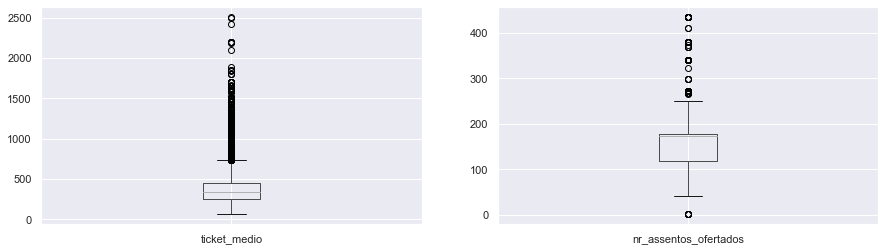

In [ ]:
# Verificando outliers
_, (ax1, ax2) = plt.subplots(1, 2)
df[['ticket_medio']].boxplot(ax=ax1)
df[['nr_assentos_ofertados']].boxplot(ax=ax2)
plt.show()

Obs.: Após alguns testes, identificamos que a remoção de _outliers_ não teve impacto positivo no modelo.

___
### Selecionando as _features_

In [ ]:
cat_columns = ['hr_partida_real', # hora
               #'nr_ano', # ano
               'nr_mes', # mes
               'nm_dia_semana', # dia
               'sg_empresa_icao', # empresa
               'sg_icao_origem', # origem
               'sg_icao_destino', # destino
               'sg_equipamento_icao' #aeronave
              ]
num_columns = ['nr_assentos_ofertados',
               'ticket_medio',
               'dolar'
              ]
target = 'prejuizo'
df_temp = df[cat_columns + num_columns + [target]]

In [ ]:
df_temp.shape

(2022706, 11)

___
### Treinando e testando o modelo

In [ ]:
# Divisão entre features e target
X = df_temp.drop(target,axis=1)
y = df_temp[target]

In [ ]:
# Transformações
transformation = make_column_transformer(
    (MinMaxScaler(),num_columns),
    (OneHotEncoder(handle_unknown = 'ignore'),cat_columns),
    remainder='passthrough'
    )

In [ ]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2222)

In [ ]:
# Balanceamento (UnderSampling)
X_train, y_train = RandomUnderSampler(random_state = 2222).fit_resample(X_train,y_train)

In [ ]:
y_train.value_counts()

1    90409
0    90409
Name: prejuizo, dtype: int64

In [ ]:
# Treino
rf = RandomForestClassifier(n_jobs = -1, bootstrap = True, max_depth = 70, min_samples_leaf = 4,
                            min_samples_split = 2, n_estimators=90, random_state=2222)
final = make_pipeline(transformation,rf)
final.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['nr_assentos_ofertados',
                                                   'ticket_medio', 'dolar']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hr_partida_real', 'nr_mes',
                                                   'nm_dia_semana',
                                                   'sg_empresa_icao',
                                                   'sg_icao_origem',
                                                   'sg_icao_destino',
                                                   'sg_equipamento_icao'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=70, min_samples_leaf=4,
                                        n_estimators=90, n_jobs=-1,
                                        random_state=2222))])

In [ ]:
# Teste
y_pred = final.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87    381940
           1       0.16      0.73      0.27     22602

    accuracy                           0.77    404542
   macro avg       0.57      0.75      0.57    404542
weighted avg       0.93      0.77      0.83    404542



___
## Primeiras considerações

Este modelo constitui um sistema de alerta para casos de voos que podem gerar prejuízo para as empresas aéreas.

Considerando a métrica de revocação, o modelo é eficiente para capturar 73% dos casos que realmente geram prejuízo (categoria 1).

Ao analisar uma tabela de voos, podemos utilizar a função _predict_proba_ para ordernar essa tabela e trazer os voos que possuem uma maior probabilidade de gerar prejuízo para o topo, sugerindo uma ordem de prioridade para averiguação e possível tomada de providências. Faremos isso mais adiante, após as otimizações.

<br>  <br>

___
### Otimizações

In [ ]:
# Montando pipeline
pipe = make_pipeline(transformation,RandomForestClassifier(n_jobs=-1,random_state=2222))

In [ ]:
# Listando possiveis parâmetros
list(pipe.get_params().keys())

['memory',
 'steps',
 'verbose',
 'columntransformer',
 'randomforestclassifier',
 'columntransformer__n_jobs',
 'columntransformer__remainder',
 'columntransformer__sparse_threshold',
 'columntransformer__transformer_weights',
 'columntransformer__transformers',
 'columntransformer__verbose',
 'columntransformer__minmaxscaler',
 'columntransformer__onehotencoder',
 'columntransformer__minmaxscaler__copy',
 'columntransformer__minmaxscaler__feature_range',
 'columntransformer__onehotencoder__categories',
 'columntransformer__onehotencoder__drop',
 'columntransformer__onehotencoder__dtype',
 'columntransformer__onehotencoder__handle_unknown',
 'columntransformer__onehotencoder__sparse',
 'randomforestclassifier__bootstrap',
 'randomforestclassifier__ccp_alpha',
 'randomforestclassifier__class_weight',
 'randomforestclassifier__criterion',
 'randomforestclassifier__max_depth',
 'randomforestclassifier__max_features',
 'randomforestclassifier__max_leaf_nodes',
 'randomforestclassifier__ma

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
bootstrap = [True, False]

In [ ]:
grid = {f'randomforestclassifier__n_estimators':n_estimators,
        f'randomforestclassifier__max_depth':max_depth,
        f'randomforestclassifier__min_samples_leaf':min_samples_leaf,
        f'randomforestclassifier__min_samples_split':min_samples_split,
        f'randomforestclassifier__bootstrap':bootstrap
        }

In [ ]:
gcv = RandomizedSearchCV(pipe,param_distributions=grid,cv=3,n_iter=5,
                         return_train_score=True,verbose=5,scoring='recall',random_state=2222)
gcv.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True, score=(train=0.708, test=0.669), total=  13.3s
[CV] randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV]  randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True, score=(train=0.702, test=0.660), total=   9.6s
[CV] randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


[CV]  randomforestclassifier__n_estimators=30, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__max_depth=20, randomforestclassifier__bootstrap=True, score=(train=0.699, test=0.657), total=   9.9s
[CV] randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.5s remaining:    0.0s


[CV]  randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True, score=(train=0.932, test=0.734), total=  13.3s
[CV] randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.4s remaining:    0.0s


[CV]  randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True, score=(train=0.933, test=0.731), total=  14.1s
[CV] randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True 
[CV]  randomforestclassifier__n_estimators=10, randomforestclassifier__min_samples_split=5, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__max_depth=110, randomforestclassifier__bootstrap=True, score=(train=0.934, test=0.727), total=  13.1s
[CV] randomforestclassifier__n_estimators=40, randomforestclassifier__min_samples_split=2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__max_depth=None, randomforestclassifier__bootstrap=True 
[CV]  randomforestclassifier__n_estimators=40, 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('minmaxscaler',
                                                                               MinMaxScaler(),
                                                                               ['nr_assentos_ofertados',
                                                                                'ticket_medio',
                                                                                'dolar']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['hr_partida_real',
                                                                                'nr_mes',
                                                                                'nm_dia_semana',
                                                                                'sg_empresa_icao',
                                                                                'sg_icao_origem',
                                                                                'sg_ica...
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50,
                                                                              60,
                                                                              70,
                                                                              80,
                                                                              90,
                                                                              100,
                                                                              110,
                                                                              None],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 20,
                                                                                 30,
                                                                                 40,
                                                                                 50,
                                                                                 60,
                                                                                 70,
                                                                                 80,
                                                                                 90,
                                                                                 100,
    

In [ ]:
gcv.best_params_

{'randomforestclassifier__n_estimators': 40,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__max_depth': 80,
 'randomforestclassifier__bootstrap': True}

In [ ]:
gcv.best_score_

0.7383557136975843

___
## Resultado final do modelo

In [ ]:
# Treino
rf = RandomForestClassifier(n_jobs = -1, bootstrap = True, max_depth = 80, min_samples_leaf = 2,
                            min_samples_split = 2, n_estimators=40, random_state=2222)
final = make_pipeline(transformation,rf)
final.fit(X_train,y_train)

# Teste
y_pred = final.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87    381940
           1       0.17      0.75      0.28     22602

    accuracy                           0.78    404542
   macro avg       0.58      0.77      0.57    404542
weighted avg       0.94      0.78      0.84    404542



___
## Produto para entrega

Ao analisar uma tabela de voos futuros, o modelo prevê a probabilidade de cada voo gerar prejuízo com baixa ocupação (LF < 0.5) e ordena a tabela trazendo os casos mais prováveis para o topo, assim sugerindo à empresa uma prioridade para a averiguação e possível tomada de providências. Veja o exemplo abaixo:


In [ ]:
# Predizendo a probabilidade dos voos darem prejuízo
prob_prejuizo = final.predict_proba(X_test)

In [ ]:
# Montando base com probabilidade de prejuízo dos voos
df_prob = pd.DataFrame({'prob_prejuizo':[x[1].round(4) for x in prob_prejuizo]})
df_prejuizo = X_test.reset_index(drop=True)
entrega = pd.concat([df_prob,df_prejuizo],axis=1)

In [ ]:
# Base ordenada, como sugestão de prioridades de averiguação para a empresa
entrega = entrega.sort_values(by='prob_prejuizo',ascending=False).reset_index(drop=True)

In [ ]:
entrega.head(100)

,prob_prejuizo,hr_partida_real,nr_mes,nm_dia_semana,sg_empresa_icao,sg_icao_origem,sg_icao_destino,sg_equipamento_icao,nr_assentos_ofertados,ticket_medio,dolar
0,0.9960,12,6,SEG,AZU,SBCP,SBRJ,AT72,70,420.0,3.8518
1,0.9953,18,4,SEX,AZU,SBRJ,SBCP,AT72,70,455.0,3.1758
2,0.9944,18,4,QUI,AZU,SBRJ,SBCP,AT72,70,455.0,3.1758
3,0.9939,18,5,QUA,AZU,SBRJ,SBCP,AT72,70,499.0,3.2262
4,0.9931,18,9,SEX,AZU,SBRJ,SBCP,AT72,70,528.0,3.1614
5,0.9923,8,11,QUA,AZU,SBRJ,SBCP,AT72,70,534.0,3.2726
6,0.9891,8,11,QUI,AZU,SBRJ,SBCP,AT72,70,534.0,3.2726
7,0.9885,8,8,QUI,AZU,SBRJ,SBCP,AT72,70,507.0,3.1474
8,0.9883,13,2,QUA,AZU,SBCP,SBRJ,AT72,70,611.0,3.2458
9,0.9882,18,3,QUI,AZU,SBRJ,SBCP,AT72,70,513.0,3.1230
